In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from examples.cosim_example.cosim_example import run_simulation
from vessim.analysis import plot_accumulated_emissions, plot_grid_power_usage, plot_production_consumption_delta, plot_battery_soc, plot_carbon_intensity
import seaborn as sns

sns.set(style='ticks', context="notebook")

In [2]:
run_simulation(carbon_aware=False, result_csv="baseline.csv")
with open("baseline.csv", "r") as f:
    baseline_experiment = pd.read_csv(f, index_col=0, parse_dates=True)

2023-09-11 09:18:59.935 | INFO     | mosaik.scenario:start:255 - Starting "Consumer" as "Consumer-0" ...
2023-09-11 09:18:59.951 | INFO     | mosaik.scenario:start:255 - Starting "Generator" as "Generator-0" ...
2023-09-11 09:19:00.162 | INFO     | mosaik.scenario:start:255 - Starting "CarbonApi" as "CarbonApi-0" ...
2023-09-11 09:19:00.168 | INFO     | mosaik.scenario:start:255 - Starting "Microgrid" as "Microgrid-0" ...
2023-09-11 09:19:00.172 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-09-11 09:19:00.173 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-09-11 09:19:00.174 | INFO     | mosaik.scenario:start:255 - Starting "Monitor" as "Monitor-0" ...
2023-09-11 09:19:00.183 | INFO     | mosaik.scenario:run:532 - St

In [3]:
run_simulation(carbon_aware=True, result_csv="carbon_aware.csv")
with open("carbon_aware.csv", "r") as f:
    carbon_aware_experiment = pd.read_csv(f, index_col=0, parse_dates=True)

2023-09-11 09:19:32.478 | INFO     | mosaik.scenario:start:255 - Starting "Consumer" as "Consumer-0" ...
2023-09-11 09:19:32.484 | INFO     | mosaik.scenario:start:255 - Starting "Generator" as "Generator-0" ...
2023-09-11 09:19:32.660 | INFO     | mosaik.scenario:start:255 - Starting "CarbonApi" as "CarbonApi-0" ...
2023-09-11 09:19:32.666 | INFO     | mosaik.scenario:start:255 - Starting "Cacu" as "Cacu-0" ...
2023-09-11 09:19:32.671 | INFO     | mosaik.scenario:start:255 - Starting "Microgrid" as "Microgrid-0" ...
2023-09-11 09:19:32.675 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-09-11 09:19:32.676 | WARNING  | mosaik.scenario:_check_attributes_values:730 - A connection between persistent and trigger attributes is not recommended.This might cause problems in the simulation!
2023-09-11 09:19:32.678 | INFO     | mosaik.scenario:start:255 - Starti

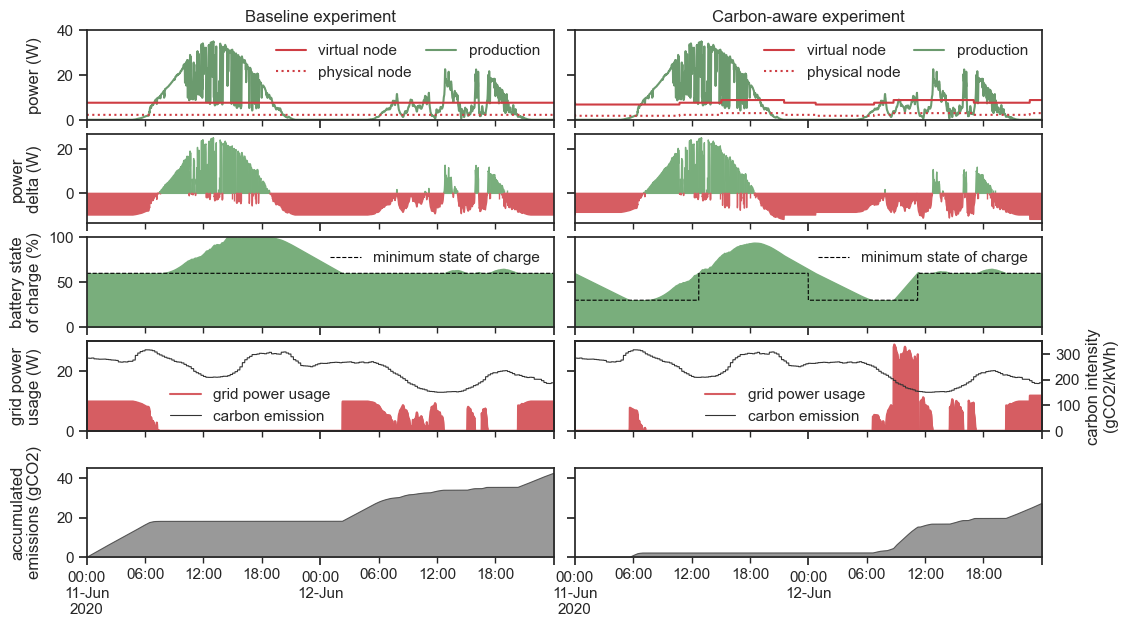

In [4]:
def plot_evaluation(data, axs, title: str, left: bool):
    axs[0].set_title(title)

    # Plot Production and Consumption
    data["p_solar"].plot(ax=axs[0], color="#6b9a6e", label="production")
    data["computing_system_info.mpm0"].plot(ax=axs[0], color="#ce3d43", label="physical node", linestyle=":")
    data["computing_system_info.mpm1"].plot(ax=axs[0], color="#ce3d43", label="virtual node")
    axs[0].set_ylabel("power (W)")
    axs[0].set_ylim(0, 40)
    h, l = axs[0].get_legend_handles_labels()
    axs[0].legend([h[2], h[1], h[0]], [l[2], l[1], l[0]], frameon=False, ncol=2, columnspacing=0.9)

    # Plot Production/Consumption delta
    plot_production_consumption_delta(axs[1], data["p_solar"], data["p_computing_system"])
    axs[1].set_yticks([0, 20])
    axs[1].set_yticks([], minor=True)

    # Plot Battery State of Charge
    plot_battery_soc(axs[2], data["battery_soc"], data["battery_min_soc"])

    # Plot grid power and carbon emission
    plot_grid_power_usage(axs[3], data["p_grid"])
    axs[3].set_ylim(0, 30)
    axs[3].set_yticks([0, 20])
    ax3_twin = axs[3].twinx()
    plot_carbon_intensity(ax3_twin, data["carbon_intensity"])
    ax3_twin.set_ylim(0, 350)
    if left:
        ax3_twin.set_ylabel("")
        ax3_twin.set_yticks([])
        x = 0.35
    else:
        ax3_twin.set_ylabel("carbon intensity\n(gCO2/kWh)")
        ax3_twin.set_yticks([0, 100, 200, 300])
        x = 0.45
    h1, l1 = axs[3].get_legend_handles_labels()
    h2, l2 = ax3_twin.get_legend_handles_labels()
    axs[3].legend(h1 + h2, ["grid power usage", "carbon emission"], frameon=False, loc='upper center', bbox_to_anchor=(x, 0.63))

    axs[4].set_axis_off()

    # Plot accumulated carbon emission
    total_emission = plot_accumulated_emissions(axs[5], data["p_grid"], data["carbon_intensity"])
    axs[5].set_ylim(0, 45)
    axs[5].set_yticks([0, 20, 40])
    axs[5].set_xlabel("")
    axs[5].set_yticks([], minor=True)

    return total_emission


fig, axs = plt.subplots(ncols=2, nrows=6, sharex="col", sharey="row", figsize=(10,5.6), height_ratios=[1, 1, 1, 1, 0.1, 1])
fig.tight_layout(pad=0)
e1 = plot_evaluation(baseline_experiment, axs[:,0], title="Baseline experiment", left=True)
e2 = plot_evaluation(carbon_aware_experiment, axs[:,1], title="Carbon-aware experiment", left=False)
fig.align_ylabels()

In [5]:
1 - (e2 / e1)

0.3591342662273671